# Tutorial - Implementing a custom analysis block in Lightwood


## Introduction

As you might already know, Lightwood is designed to be a flexible machine learning (ML) library that is able to abstract and automate the entire ML pipeline. Crucially, it is also designed to be extended or modified very easily according to your needs, essentially offering the entire spectrum between fully automated AutoML and a lightweight wrapper for customized ML pipelines.

As such, we can identify several different customizable "phases" in the process. The relevant phase for this tutorial is the "analysis" that comes after a predictor has been trained. The goal of this phase is to generate useful insights, like accuracy metrics, confusion matrices, feature importance, etc. These particular examples are all included in the core analysis procedure that Lightwood executes.

However, the analysis procedure is structured into a sequential execution of "analysis blocks". Each analysis block should generate a well-defined set of insights, as well as handling any actions regarding these at inference time.

As an example, one of the core blocks is the Inductive Conformal Prediction (`ICP`) block, which handles the confidence estimation of all Lightwood predictors. The logic within can be complex at times, but thanks to the block abstraction we can deal with it in a structured manner. As this `ICP` block is used when generating predictions, it implements the two main methods that the `BaseAnalysisBlock` class specifies: `.analyze()` to setup everything that is needed, and `.explain()` to actually estimate the confidence in any given prediction.


## Objective

In this tutorial, we will go through the steps required to implement your own analysis blocks to customize the insights of any Lightwood predictor!

In particular, we will implement a "model correlation heatmap" block: we want to compare the predictions of all mixers inside a `BestOf` ensemble object, to understand how they might differ in their overall behavior.

In [18]:
from typing import Dict, Tuple
import pandas as pd
import lightwood
lightwood.__version__

'1.3.0'

## Step 1: figuring out what we need

When designing an analysis block, an important choice needs to be made: will this block operate when calling the predictor? Or is it only going to describe its performance once in the held-out validation dataset?

Being in the former case means we need to implement both `.analyze()` and `.explain()` methods, while the latter case only needs an `.analyze()` method. Our `ModelCorrelationHeatmap` belongs to this second category.

Let's start the implementation by inheriting from `BaseAnalysisBlock`:

In [19]:
from lightwood.analysis import BaseAnalysisBlock

class ModelCorrelationHeatmap(BaseAnalysisBlock):
    def __init__(self):
        super().__init__()
        
    def analyze(self, info: Dict[str, object], **kwargs) -> Dict[str, object]:
        return info

    def explain(self,
                row_insights: pd.DataFrame,
                global_insights: Dict[str, object], **kwargs) -> Tuple[pd.DataFrame, Dict[str, object]]:
        
        return row_insights, global_insights

In [20]:
ModelCorrelationHeatmap()  # this should work

Right now, our newly created analysis block doesn't do much, apart from returning the `info` and insights (`row_insights` and `global_insights`) exactly as it received them from the previous block.

As previously discussed, we only need to implement a procedure that runs post-training, no action is required at inference time. This means we can use the default `.explain()` behavior in the parent class:

In [22]:
class ModelCorrelationHeatmap(BaseAnalysisBlock):
    def __init__(self):
        super().__init__()
        
    def analyze(self, info: Dict[str, object], **kwargs) -> Dict[str, object]:
        return info

## Step 2: Implementing the custom analysis block

Okay, now for the fun bit: we have to implement a correlation heatmap between the predictions of all mixers inside a `BestOf` ensemble. This is currently the only ensemble implemented in Lightwood, but it is a good idea to explicitly check that the type of the ensemble is what we expect.

A natural question to ask at this point is: what information do we have to implement the procedure? You'll note that, apart from the `info` dictionary, we receive a `kwargs` dictionary. You can check out the full documentation for more details, but the keys (and respective value types) exposed in this object by default are:

In [24]:
kwargs = {
        'predictor': 'lightwood.ensemble.BaseEnsemble',
        'target': 'str',
        'input_cols': 'list',
        'dtype_dict': 'dict',
        'normal_predictions': 'pd.DataFrame',
        'data': 'pd.DataFrame',
        'train_data': 'lightwood.data.encoded_ds.EncodedDs',
        'encoded_val_data': 'lightwood.data.encoded_ds.EncodedDs',
        'is_classification': 'bool',
        'is_numerical': 'bool',
        'is_multi_ts': 'bool',
        'stats_info': 'lightwood.api.types.StatisticalAnalysis',
        'ts_cfg': 'lightwood.api.types.TimeseriesSettings',
        'accuracy_functions': 'list',
        'has_pretrained_text_enc': 'bool'
}

As you can see there is lots to work with, but for this example we will focus on using:

1. The `predictor` ensemble
2. The `encoded_val_data` to generate predictions for each mixer inside the ensemble

And the insight we're want to produce is a matrix that compares the output of all mixers and computes the correlation between them.

Let's implement the algorithm:

In [70]:
from typing import Dict
from types import SimpleNamespace

import numpy as np

from lightwood.ensemble import BestOf
from lightwood.analysis import BaseAnalysisBlock


class ModelCorrelationHeatmap(BaseAnalysisBlock):
    def __init__(self):
        super().__init__()
        
    def analyze(self, info: Dict[str, object], **kwargs) -> Dict[str, object]:
        ns = SimpleNamespace(**kwargs)
        
        # only triggered with the right type of ensemble
        if isinstance(ns.predictor, BestOf):
            
            # store prediction from every mixer
            all_predictions = []

            for mixer in ns.predictor.mixers:
                predictions = mixer(ns.encoded_val_data).values  # retrieve np.ndarray from the returned pd.DataFrame
                all_predictions.append(predictions.flatten().astype(int))  # flatten and cast labels to int
                
            # calculate correlation matrix
            corrs = np.corrcoef(np.array(all_predictions))
            
            # save inside `info` object
            info['mixer_correlation'] = corrs
        
        return info


Notice the use of `SimpleNamespace` for dot notation accessors.

The procedure above is fairly straightforward, as we leverage numpy's `corrcoef()` function to generate the matrix. 

Finally, it is very important to add the output to `info` so that it is saved inside the actual predictor object. 

## Step 3: Exposing the block to Lightwood


To use this in an arbitrary script, we need to add the above class (and all necessary imports) to a `.py` file inside one of the following directories:

* `~/lightwood_modules` (where `~` is your home directory, e.g. `/Users/username/` for macOS and `/home/username/` for linux
* `/etc/lightwood_modules`

Lightwood will scan these directories and import any class so that they can be found and used by the `JsonAI` code generating module.

**To continue, please save the code cell above as `model_correlation.py` in one of the indicated directories.**

## Step 4: Final test run

Ok! Everything looks set to try out our custom block. Let's generate a predictor for [this](https://github.com/mindsdb/lightwood/blob/stable/tests/data/hdi.csv) sample dataset, and see whether our new insights are any good.

First, it is important to add our `ModelCorrelationHeatmap` to the `analysis_blocks` attribute of the Json AI object that will generate your predictor code. 

In [71]:
from lightwood.api.high_level import ProblemDefinition, json_ai_from_problem

# read dataset
df = pd.read_csv('https://raw.githubusercontent.com/mindsdb/lightwood/stable/tests/data/hdi.csv')

# define the predictive task
pdef = ProblemDefinition.from_dict({
    'target': 'Development Index',         # column you want to predict
})

# generate the Json AI intermediate representation from the data and its corresponding settings
json_ai = json_ai_from_problem(df, problem_definition=pdef)

# add the custom list of analysis blocks; in this case, composed of a single block
json_ai.analysis_blocks = [{
    'module': 'model_correlation.ModelCorrelationHeatmap',
    'args': {}
}]

INFO:lightwood-1011:Dropping features: []
INFO:lightwood-1011:Analyzing a sample of 222
INFO:lightwood-1011:from a total population of 225, this is equivalent to 98.7% of your data.
INFO:lightwood-1011:Using 15 processes to deduct types.
INFO:lightwood-1011:Starting statistical analysis
INFO:lightwood-1011:Finished statistical analysis


We can take a look at the respective Json AI key just to confirm our newly added analysis block is in there:

In [72]:
json_ai.analysis_blocks

[{'module': 'model_correlation.ModelCorrelationHeatmap', 'args': {}}]

Now we are ready to create a predictor from this Json AI, and subsequently train it:

In [73]:
from lightwood.api.high_level import code_from_json_ai, predictor_from_code

code = code_from_json_ai(json_ai)
predictor = predictor_from_code(code)

predictor.learn(df)

INFO:lightwood-1011:Dropping features: []
INFO:lightwood-1011:Starting statistical analysis
INFO:lightwood-1011:Finished statistical analysis
INFO:lightwood-1011:Cleaning the data
INFO:lightwood-1011:Preparing the encoders
INFO:lightwood-1011:Encoder prepping dict length of: 1
INFO:lightwood-1011:Encoder prepping dict length of: 2
INFO:lightwood-1011:Encoder prepping dict length of: 3
INFO:lightwood-1011:Encoder prepping dict length of: 4
INFO:lightwood-1011:Encoder prepping dict length of: 5
INFO:lightwood-1011:Encoder prepping dict length of: 6
INFO:lightwood-1011:Encoder prepping dict length of: 7
INFO:lightwood-1011:Done running for: Development Index
INFO:lightwood-1011:Done running for: Population
INFO:lightwood-1011:Done running for: Area (sq. mi.)
INFO:lightwood-1011:Done running for: Pop. Density 
INFO:lightwood-1011:Done running for: GDP ($ per capita)
INFO:lightwood-1011:Done running for: Literacy (%)
INFO:lightwood-1011:Done running for: Infant mortality 
INFO:lightwood-101

DEBUG:lightwood-1011:Loss @ epoch 110: 1.1592680215835571
DEBUG:lightwood-1011:Loss @ epoch 111: 1.1560531854629517
DEBUG:lightwood-1011:Loss @ epoch 112: 1.1529642343521118
DEBUG:lightwood-1011:Loss @ epoch 113: 1.1503714323043823
DEBUG:lightwood-1011:Loss @ epoch 114: 1.147828459739685
DEBUG:lightwood-1011:Loss @ epoch 115: 1.1409956216812134
DEBUG:lightwood-1011:Loss @ epoch 116: 1.1384369134902954
DEBUG:lightwood-1011:Loss @ epoch 117: 1.1353813409805298
DEBUG:lightwood-1011:Loss @ epoch 118: 1.1324419975280762
DEBUG:lightwood-1011:Loss @ epoch 119: 1.1300077438354492
DEBUG:lightwood-1011:Loss @ epoch 120: 1.1276044845581055
DEBUG:lightwood-1011:Loss @ epoch 121: 1.1211178302764893
DEBUG:lightwood-1011:Loss @ epoch 122: 1.1186940670013428
DEBUG:lightwood-1011:Loss @ epoch 123: 1.1157807111740112
DEBUG:lightwood-1011:Loss @ epoch 124: 1.1129751205444336
DEBUG:lightwood-1011:Loss @ epoch 125: 1.1106899976730347
DEBUG:lightwood-1011:Loss @ epoch 126: 1.1084178686141968
DEBUG:lightwood

DEBUG:lightwood-1011:Loss @ epoch 252: 0.810451090335846
DEBUG:lightwood-1011:Loss @ epoch 253: 0.8067992329597473
DEBUG:lightwood-1011:Loss @ epoch 254: 0.8054236769676208
DEBUG:lightwood-1011:Loss @ epoch 255: 0.8035988211631775
DEBUG:lightwood-1011:Loss @ epoch 256: 0.8017988801002502
DEBUG:lightwood-1011:Loss @ epoch 257: 0.8007737994194031
DEBUG:lightwood-1011:Loss @ epoch 258: 0.7995227575302124
DEBUG:lightwood-1011:Loss @ epoch 259: 0.7959653735160828
DEBUG:lightwood-1011:Loss @ epoch 260: 0.7946229577064514
DEBUG:lightwood-1011:Loss @ epoch 261: 0.7928213477134705
DEBUG:lightwood-1011:Loss @ epoch 262: 0.7910441756248474
DEBUG:lightwood-1011:Loss @ epoch 263: 0.7900481224060059
DEBUG:lightwood-1011:Loss @ epoch 264: 0.7888175249099731
DEBUG:lightwood-1011:Loss @ epoch 265: 0.7853183746337891
DEBUG:lightwood-1011:Loss @ epoch 266: 0.7839962244033813
DEBUG:lightwood-1011:Loss @ epoch 267: 0.7822188138961792
DEBUG:lightwood-1011:Loss @ epoch 268: 0.7804620862007141
DEBUG:lightwood

DEBUG:lightwood-1011:Loss @ epoch 394: 0.6031119227409363
DEBUG:lightwood-1011:Loss @ epoch 395: 0.6026865839958191
DEBUG:lightwood-1011:Loss @ epoch 396: 0.6019470691680908
DEBUG:lightwood-1011:Loss @ epoch 397: 0.5997323989868164
DEBUG:lightwood-1011:Loss @ epoch 398: 0.5988850593566895
DEBUG:lightwood-1011:Loss @ epoch 399: 0.5976197719573975
DEBUG:lightwood-1011:Loss @ epoch 400: 0.5963553190231323
DEBUG:lightwood-1011:Loss @ epoch 401: 0.595933198928833
DEBUG:lightwood-1011:Loss @ epoch 402: 0.5951997637748718
DEBUG:lightwood-1011:Loss @ epoch 403: 0.593011736869812
DEBUG:lightwood-1011:Loss @ epoch 404: 0.5921814441680908
DEBUG:lightwood-1011:Loss @ epoch 405: 0.5909314155578613
DEBUG:lightwood-1011:Loss @ epoch 406: 0.5896862149238586
DEBUG:lightwood-1011:Loss @ epoch 407: 0.5892735123634338
DEBUG:lightwood-1011:Loss @ epoch 408: 0.5885460376739502
DEBUG:lightwood-1011:Loss @ epoch 409: 0.5863622426986694
DEBUG:lightwood-1011:Loss @ epoch 410: 0.5855305790901184
DEBUG:lightwood-

DEBUG:lightwood-1011:Loss @ epoch 536: 0.47090286016464233
DEBUG:lightwood-1011:Loss @ epoch 537: 0.4699815511703491
DEBUG:lightwood-1011:Loss @ epoch 538: 0.4690350890159607
DEBUG:lightwood-1011:Loss @ epoch 539: 0.4688645005226135
DEBUG:lightwood-1011:Loss @ epoch 540: 0.46842411160469055
DEBUG:lightwood-1011:Loss @ epoch 541: 0.4669750928878784
DEBUG:lightwood-1011:Loss @ epoch 542: 0.46642541885375977
DEBUG:lightwood-1011:Loss @ epoch 543: 0.46549955010414124
DEBUG:lightwood-1011:Loss @ epoch 544: 0.4645457863807678
DEBUG:lightwood-1011:Loss @ epoch 545: 0.4643654227256775
DEBUG:lightwood-1011:Loss @ epoch 546: 0.4639209508895874
DEBUG:lightwood-1011:Loss @ epoch 547: 0.4624875783920288
DEBUG:lightwood-1011:Loss @ epoch 548: 0.4619481861591339
DEBUG:lightwood-1011:Loss @ epoch 549: 0.46103256940841675
DEBUG:lightwood-1011:Loss @ epoch 550: 0.4600990414619446
DEBUG:lightwood-1011:Loss @ epoch 551: 0.45993712544441223
DEBUG:lightwood-1011:Loss @ epoch 552: 0.45951077342033386
DEBUG:l

DEBUG:lightwood-1011:Loss @ epoch 677: 0.3849989175796509
DEBUG:lightwood-1011:Loss @ epoch 678: 0.38476279377937317
DEBUG:lightwood-1011:Loss @ epoch 679: 0.38383564352989197
DEBUG:lightwood-1011:Loss @ epoch 680: 0.3835124969482422
DEBUG:lightwood-1011:Loss @ epoch 681: 0.38285431265830994
DEBUG:lightwood-1011:Loss @ epoch 682: 0.3821337819099426
DEBUG:lightwood-1011:Loss @ epoch 683: 0.38209930062294006
DEBUG:lightwood-1011:Loss @ epoch 684: 0.3818766474723816
DEBUG:lightwood-1011:Loss @ epoch 685: 0.3809750974178314
DEBUG:lightwood-1011:Loss @ epoch 686: 0.38065609335899353
DEBUG:lightwood-1011:Loss @ epoch 687: 0.3800048530101776
DEBUG:lightwood-1011:Loss @ epoch 688: 0.3792880177497864
DEBUG:lightwood-1011:Loss @ epoch 689: 0.37925222516059875
DEBUG:lightwood-1011:Loss @ epoch 690: 0.37903448939323425
DEBUG:lightwood-1011:Loss @ epoch 691: 0.3781534433364868
DEBUG:lightwood-1011:Loss @ epoch 692: 0.37784743309020996
DEBUG:lightwood-1011:Loss @ epoch 693: 0.3772057592868805
DEBUG:

DEBUG:lightwood-1011:Loss @ epoch 818: 0.329685777425766
DEBUG:lightwood-1011:Loss @ epoch 819: 0.3291826844215393
DEBUG:lightwood-1011:Loss @ epoch 820: 0.32856738567352295
DEBUG:lightwood-1011:Loss @ epoch 821: 0.32856690883636475
DEBUG:lightwood-1011:Loss @ epoch 822: 0.3284670412540436
DEBUG:lightwood-1011:Loss @ epoch 823: 0.3278464376926422
DEBUG:lightwood-1011:Loss @ epoch 824: 0.32764551043510437
DEBUG:lightwood-1011:Loss @ epoch 825: 0.32713598012924194
DEBUG:lightwood-1011:Loss @ epoch 826: 0.3265281319618225
DEBUG:lightwood-1011:Loss @ epoch 827: 0.32653409242630005
DEBUG:lightwood-1011:Loss @ epoch 828: 0.32644712924957275
DEBUG:lightwood-1011:Loss @ epoch 829: 0.32584813237190247
DEBUG:lightwood-1011:Loss @ epoch 830: 0.32565492391586304
DEBUG:lightwood-1011:Loss @ epoch 831: 0.32516273856163025
DEBUG:lightwood-1011:Loss @ epoch 832: 0.3245604932308197
DEBUG:lightwood-1011:Loss @ epoch 833: 0.3245616853237152
DEBUG:lightwood-1011:Loss @ epoch 834: 0.32447466254234314
DEBUG

DEBUG:lightwood-1011:Loss @ epoch 959: 0.28710296750068665
DEBUG:lightwood-1011:Loss @ epoch 960: 0.28706681728363037
DEBUG:lightwood-1011:Loss @ epoch 961: 0.2865728437900543
DEBUG:lightwood-1011:Loss @ epoch 962: 0.28641003370285034
DEBUG:lightwood-1011:Loss @ epoch 963: 0.28599438071250916
DEBUG:lightwood-1011:Loss @ epoch 964: 0.2854461073875427
DEBUG:lightwood-1011:Loss @ epoch 965: 0.28545328974723816
DEBUG:lightwood-1011:Loss @ epoch 966: 0.28542038798332214
DEBUG:lightwood-1011:Loss @ epoch 967: 0.28493785858154297
DEBUG:lightwood-1011:Loss @ epoch 968: 0.28478386998176575
DEBUG:lightwood-1011:Loss @ epoch 969: 0.28437310457229614
DEBUG:lightwood-1011:Loss @ epoch 970: 0.2838298976421356
DEBUG:lightwood-1011:Loss @ epoch 971: 0.28383728861808777
DEBUG:lightwood-1011:Loss @ epoch 972: 0.2838035523891449
DEBUG:lightwood-1011:Loss @ epoch 973: 0.28331539034843445
DEBUG:lightwood-1011:Loss @ epoch 974: 0.28316277265548706
DEBUG:lightwood-1011:Loss @ epoch 975: 0.2827533781528473
DE

DEBUG:lightwood-1011:Loss @ epoch 1098: 0.2513079345226288
DEBUG:lightwood-1011:Loss @ epoch 1099: 0.2508881986141205
DEBUG:lightwood-1011:Loss @ epoch 1100: 0.2507345676422119
DEBUG:lightwood-1011:Loss @ epoch 1101: 0.2503824234008789
DEBUG:lightwood-1011:Loss @ epoch 1102: 0.24989940226078033
DEBUG:lightwood-1011:Loss @ epoch 1103: 0.24989807605743408
DEBUG:lightwood-1011:Loss @ epoch 1104: 0.2498742789030075
DEBUG:lightwood-1011:Loss @ epoch 1105: 0.24943779408931732
DEBUG:lightwood-1011:Loss @ epoch 1106: 0.24929919838905334
DEBUG:lightwood-1011:Loss @ epoch 1107: 0.24896283447742462
DEBUG:lightwood-1011:Loss @ epoch 1108: 0.24849332869052887
DEBUG:lightwood-1011:Loss @ epoch 1109: 0.24849607050418854
DEBUG:lightwood-1011:Loss @ epoch 1110: 0.2484772950410843
DEBUG:lightwood-1011:Loss @ epoch 1111: 0.24805518984794617
DEBUG:lightwood-1011:Loss @ epoch 1112: 0.24790072441101074
DEBUG:lightwood-1011:Loss @ epoch 1113: 0.24755753576755524
DEBUG:lightwood-1011:Loss @ epoch 1114: 0.2470

DEBUG:lightwood-1011:Loss @ epoch 1236: 0.22101546823978424
DEBUG:lightwood-1011:Loss @ epoch 1237: 0.22067740559577942
DEBUG:lightwood-1011:Loss @ epoch 1238: 0.2205325961112976
DEBUG:lightwood-1011:Loss @ epoch 1239: 0.22023983299732208
DEBUG:lightwood-1011:Loss @ epoch 1240: 0.21982675790786743
DEBUG:lightwood-1011:Loss @ epoch 1241: 0.21985341608524323
DEBUG:lightwood-1011:Loss @ epoch 1242: 0.21984554827213287
DEBUG:lightwood-1011:Loss @ epoch 1243: 0.21947723627090454
DEBUG:lightwood-1011:Loss @ epoch 1244: 0.21932096779346466
DEBUG:lightwood-1011:Loss @ epoch 1245: 0.21901777386665344
DEBUG:lightwood-1011:Loss @ epoch 1246: 0.218614861369133
DEBUG:lightwood-1011:Loss @ epoch 1247: 0.2186294049024582
DEBUG:lightwood-1011:Loss @ epoch 1248: 0.21862190961837769
DEBUG:lightwood-1011:Loss @ epoch 1249: 0.21828778088092804
DEBUG:lightwood-1011:Loss @ epoch 1250: 0.21814247965812683
DEBUG:lightwood-1011:Loss @ epoch 1251: 0.21785743534564972
DEBUG:lightwood-1011:Loss @ epoch 1252: 0.21

DEBUG:lightwood-1011:Loss @ epoch 1374: 0.1962687224149704
DEBUG:lightwood-1011:Loss @ epoch 1375: 0.19595889747142792
DEBUG:lightwood-1011:Loss @ epoch 1376: 0.19582639634609222
DEBUG:lightwood-1011:Loss @ epoch 1377: 0.1955992877483368
DEBUG:lightwood-1011:Loss @ epoch 1378: 0.19527781009674072
DEBUG:lightwood-1011:Loss @ epoch 1379: 0.19529689848423004
DEBUG:lightwood-1011:Loss @ epoch 1380: 0.19528234004974365
DEBUG:lightwood-1011:Loss @ epoch 1381: 0.1949847787618637
DEBUG:lightwood-1011:Loss @ epoch 1382: 0.19484879076480865
DEBUG:lightwood-1011:Loss @ epoch 1383: 0.1946190744638443
DEBUG:lightwood-1011:Loss @ epoch 1384: 0.19428853690624237
DEBUG:lightwood-1011:Loss @ epoch 1385: 0.19430798292160034
DEBUG:lightwood-1011:Loss @ epoch 1386: 0.19429464638233185
DEBUG:lightwood-1011:Loss @ epoch 1387: 0.19399286806583405
DEBUG:lightwood-1011:Loss @ epoch 1388: 0.1938483566045761
DEBUG:lightwood-1011:Loss @ epoch 1389: 0.19363145530223846
DEBUG:lightwood-1011:Loss @ epoch 1390: 0.193

DEBUG:lightwood-1011:Loss @ epoch 1512: 0.17521624267101288
DEBUG:lightwood-1011:Loss @ epoch 1513: 0.17496487498283386
DEBUG:lightwood-1011:Loss @ epoch 1514: 0.1748405247926712
DEBUG:lightwood-1011:Loss @ epoch 1515: 0.17467360198497772
DEBUG:lightwood-1011:Loss @ epoch 1516: 0.17440292239189148
DEBUG:lightwood-1011:Loss @ epoch 1517: 0.1744282990694046
DEBUG:lightwood-1011:Loss @ epoch 1518: 0.1744133085012436
DEBUG:lightwood-1011:Loss @ epoch 1519: 0.17414554953575134
DEBUG:lightwood-1011:Loss @ epoch 1520: 0.1740017682313919
DEBUG:lightwood-1011:Loss @ epoch 1521: 0.17383970320224762
DEBUG:lightwood-1011:Loss @ epoch 1522: 0.17358581721782684
DEBUG:lightwood-1011:Loss @ epoch 1523: 0.17361733317375183
DEBUG:lightwood-1011:Loss @ epoch 1524: 0.17359885573387146
DEBUG:lightwood-1011:Loss @ epoch 1525: 0.1733289659023285
DEBUG:lightwood-1011:Loss @ epoch 1526: 0.17320366203784943
DEBUG:lightwood-1011:Loss @ epoch 1527: 0.17304076254367828
DEBUG:lightwood-1011:Loss @ epoch 1528: 0.172

DEBUG:lightwood-1011:Loss @ epoch 1650: 0.1578211933374405
DEBUG:lightwood-1011:Loss @ epoch 1651: 0.15758907794952393
DEBUG:lightwood-1011:Loss @ epoch 1652: 0.15745215117931366
DEBUG:lightwood-1011:Loss @ epoch 1653: 0.15732988715171814
DEBUG:lightwood-1011:Loss @ epoch 1654: 0.15712928771972656
DEBUG:lightwood-1011:Loss @ epoch 1655: 0.15716055035591125
DEBUG:lightwood-1011:Loss @ epoch 1656: 0.15713375806808472
DEBUG:lightwood-1011:Loss @ epoch 1657: 0.15688031911849976
DEBUG:lightwood-1011:Loss @ epoch 1658: 0.15674953162670135
DEBUG:lightwood-1011:Loss @ epoch 1659: 0.15663303434848785
DEBUG:lightwood-1011:Loss @ epoch 1660: 0.15643125772476196
DEBUG:lightwood-1011:Loss @ epoch 1661: 0.1564561277627945
DEBUG:lightwood-1011:Loss @ epoch 1662: 0.15642890334129333
DEBUG:lightwood-1011:Loss @ epoch 1663: 0.15619705617427826
DEBUG:lightwood-1011:Loss @ epoch 1664: 0.15606558322906494
DEBUG:lightwood-1011:Loss @ epoch 1665: 0.15594425797462463
DEBUG:lightwood-1011:Loss @ epoch 1666: 0.

DEBUG:lightwood-1011:Loss @ epoch 1788: 0.1427428275346756
DEBUG:lightwood-1011:Loss @ epoch 1789: 0.14252613484859467
DEBUG:lightwood-1011:Loss @ epoch 1790: 0.14240111410617828
DEBUG:lightwood-1011:Loss @ epoch 1791: 0.14230778813362122
DEBUG:lightwood-1011:Loss @ epoch 1792: 0.1421545147895813
DEBUG:lightwood-1011:Loss @ epoch 1793: 0.14217177033424377
DEBUG:lightwood-1011:Loss @ epoch 1794: 0.1421399861574173
DEBUG:lightwood-1011:Loss @ epoch 1795: 0.14192552864551544
DEBUG:lightwood-1011:Loss @ epoch 1796: 0.14179201424121857
DEBUG:lightwood-1011:Loss @ epoch 1797: 0.14170072972774506
DEBUG:lightwood-1011:Loss @ epoch 1798: 0.14154213666915894
DEBUG:lightwood-1011:Loss @ epoch 1799: 0.1415504366159439
DEBUG:lightwood-1011:Loss @ epoch 1800: 0.14151498675346375
DEBUG:lightwood-1011:Loss @ epoch 1801: 0.14130143821239471
DEBUG:lightwood-1011:Loss @ epoch 1802: 0.14118224382400513
DEBUG:lightwood-1011:Loss @ epoch 1803: 0.14110232889652252
DEBUG:lightwood-1011:Loss @ epoch 1804: 0.14

DEBUG:lightwood-1011:Loss @ epoch 1926: 0.12987208366394043
DEBUG:lightwood-1011:Loss @ epoch 1927: 0.12970168888568878
DEBUG:lightwood-1011:Loss @ epoch 1928: 0.1295691728591919
DEBUG:lightwood-1011:Loss @ epoch 1929: 0.12951074540615082
DEBUG:lightwood-1011:Loss @ epoch 1930: 0.12938392162322998
DEBUG:lightwood-1011:Loss @ epoch 1931: 0.1293940246105194
DEBUG:lightwood-1011:Loss @ epoch 1932: 0.12936186790466309
DEBUG:lightwood-1011:Loss @ epoch 1933: 0.12918759882450104
DEBUG:lightwood-1011:Loss @ epoch 1934: 0.12906081974506378
DEBUG:lightwood-1011:Loss @ epoch 1935: 0.12901470065116882
DEBUG:lightwood-1011:Loss @ epoch 1936: 0.12888559699058533
DEBUG:lightwood-1011:Loss @ epoch 1937: 0.12888430058956146
DEBUG:lightwood-1011:Loss @ epoch 1938: 0.12885169684886932
DEBUG:lightwood-1011:Loss @ epoch 1939: 0.12867094576358795
DEBUG:lightwood-1011:Loss @ epoch 1940: 0.12855108082294464
DEBUG:lightwood-1011:Loss @ epoch 1941: 0.12850449979305267
DEBUG:lightwood-1011:Loss @ epoch 1942: 0.

DEBUG:lightwood-1011:Loss @ epoch 2063: 0.11914543807506561
DEBUG:lightwood-1011:Loss @ epoch 2064: 0.11911562830209732
DEBUG:lightwood-1011:Loss @ epoch 2065: 0.1189676821231842
DEBUG:lightwood-1011:Loss @ epoch 2066: 0.11886108666658401
DEBUG:lightwood-1011:Loss @ epoch 2067: 0.11882881075143814
DEBUG:lightwood-1011:Loss @ epoch 2068: 0.11873331665992737
DEBUG:lightwood-1011:Loss @ epoch 2069: 0.11872689425945282
DEBUG:lightwood-1011:Loss @ epoch 2070: 0.11869177967309952
DEBUG:lightwood-1011:Loss @ epoch 2071: 0.11853799968957901
DEBUG:lightwood-1011:Loss @ epoch 2072: 0.11844814568758011
DEBUG:lightwood-1011:Loss @ epoch 2073: 0.11842422187328339
DEBUG:lightwood-1011:Loss @ epoch 2074: 0.11832351982593536
DEBUG:lightwood-1011:Loss @ epoch 2075: 0.1183183416724205
DEBUG:lightwood-1011:Loss @ epoch 2076: 0.11828422546386719
DEBUG:lightwood-1011:Loss @ epoch 2077: 0.11813274770975113
DEBUG:lightwood-1011:Loss @ epoch 2078: 0.11803214251995087
DEBUG:lightwood-1011:Loss @ epoch 2079: 0.

DEBUG:lightwood-1011:Loss @ epoch 2200: 0.11069895327091217
DEBUG:lightwood-1011:Loss @ epoch 2201: 0.1106797605752945
DEBUG:lightwood-1011:Loss @ epoch 2202: 0.11064973473548889
DEBUG:lightwood-1011:Loss @ epoch 2203: 0.11052476614713669
DEBUG:lightwood-1011:Loss @ epoch 2204: 0.11044062674045563
DEBUG:lightwood-1011:Loss @ epoch 2205: 0.11045023798942566
DEBUG:lightwood-1011:Loss @ epoch 2206: 0.11038007587194443
DEBUG:lightwood-1011:Loss @ epoch 2207: 0.11037345230579376
DEBUG:lightwood-1011:Loss @ epoch 2208: 0.11034862697124481
DEBUG:lightwood-1011:Loss @ epoch 2209: 0.1102246418595314
DEBUG:lightwood-1011:Loss @ epoch 2210: 0.11013524234294891
DEBUG:lightwood-1011:Loss @ epoch 2211: 0.11013685166835785
DEBUG:lightwood-1011:Loss @ epoch 2212: 0.1100613996386528
DEBUG:lightwood-1011:Loss @ epoch 2213: 0.11004836857318878
DEBUG:lightwood-1011:Loss @ epoch 2214: 0.11002177000045776
DEBUG:lightwood-1011:Loss @ epoch 2215: 0.10990479588508606
DEBUG:lightwood-1011:Loss @ epoch 2216: 0.1

DEBUG:lightwood-1011:Loss @ epoch 2337: 0.10423856228590012
DEBUG:lightwood-1011:Loss @ epoch 2338: 0.10417477041482925
DEBUG:lightwood-1011:Loss @ epoch 2339: 0.10414796322584152
DEBUG:lightwood-1011:Loss @ epoch 2340: 0.10411500185728073
DEBUG:lightwood-1011:Loss @ epoch 2341: 0.10400573909282684
DEBUG:lightwood-1011:Loss @ epoch 2342: 0.10394901782274246
DEBUG:lightwood-1011:Loss @ epoch 2343: 0.103977270424366
DEBUG:lightwood-1011:Loss @ epoch 2344: 0.103921078145504
DEBUG:lightwood-1011:Loss @ epoch 2345: 0.10390277206897736
DEBUG:lightwood-1011:Loss @ epoch 2346: 0.10387607663869858
DEBUG:lightwood-1011:Loss @ epoch 2347: 0.10377556830644608
DEBUG:lightwood-1011:Loss @ epoch 2348: 0.10370795428752899
DEBUG:lightwood-1011:Loss @ epoch 2349: 0.10373787581920624
DEBUG:lightwood-1011:Loss @ epoch 2350: 0.10366767644882202
DEBUG:lightwood-1011:Loss @ epoch 2351: 0.1036471575498581
DEBUG:lightwood-1011:Loss @ epoch 2352: 0.10362187772989273
DEBUG:lightwood-1011:Loss @ epoch 2353: 0.103

DEBUG:lightwood-1011:Loss @ epoch 2474: 0.09887978434562683
DEBUG:lightwood-1011:Loss @ epoch 2475: 0.0989132896065712
DEBUG:lightwood-1011:Loss @ epoch 2476: 0.09885342419147491
DEBUG:lightwood-1011:Loss @ epoch 2477: 0.09882023185491562
DEBUG:lightwood-1011:Loss @ epoch 2478: 0.09879282116889954
DEBUG:lightwood-1011:Loss @ epoch 2479: 0.09870986640453339
DEBUG:lightwood-1011:Loss @ epoch 2480: 0.0986560583114624
DEBUG:lightwood-1011:Loss @ epoch 2481: 0.098689004778862
DEBUG:lightwood-1011:Loss @ epoch 2482: 0.09863875061273575
DEBUG:lightwood-1011:Loss @ epoch 2483: 0.09860430657863617
DEBUG:lightwood-1011:Loss @ epoch 2484: 0.09857494384050369
DEBUG:lightwood-1011:Loss @ epoch 2485: 0.09849248081445694
DEBUG:lightwood-1011:Loss @ epoch 2486: 0.098446324467659
DEBUG:lightwood-1011:Loss @ epoch 2487: 0.09848392754793167
DEBUG:lightwood-1011:Loss @ epoch 2488: 0.09842747449874878
DEBUG:lightwood-1011:Loss @ epoch 2489: 0.09839335829019547
DEBUG:lightwood-1011:Loss @ epoch 2490: 0.0983

/Users/Pato/Work/MindsDB/env/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/Pato/Work/MindsDB/env/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
INFO:lightwood-1011:Model now has a total of 595 weak estimators


Finally, we can visualize the mixer correlation matrix:

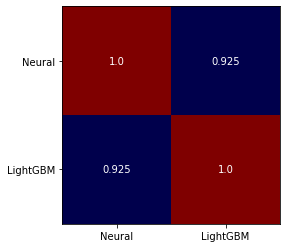

In [103]:
import matplotlib.pyplot as plt

mc = predictor.runtime_analyzer['mixer_correlation']  # newly produced insight

mixer_names = [c.__class__.__name__ for c in predictor.ensemble.mixers]

# plotting code
fig, ax = plt.subplots()
im = ax.imshow(mc, cmap='seismic')

# set ticks
ax.set_xticks(np.arange(mc.shape[0]))
ax.set_yticks(np.arange(mc.shape[1]))

# set tick labels
ax.set_xticklabels(mixer_names)
ax.set_yticklabels(mixer_names)

# show cell values
for i in range(len(mixer_names)):
    for j in range(len(mixer_names)):
        text = ax.text(j, i, round(mc[i, j], 3), ha="center", va="center", color="w")


Nice! We've just added an additional piece of insight regarding the predictor that Lightwood came up with for the task of predicting the Human Development Index of any given country.

What this matrix is telling us is that the predictions of both mixers stored in the ensemble -- Neural and LightGBM -- have a high correlation.

This is, of course, a very simple example, but it shows the convenience of such an abstraction within the broader pipeline that Lightwood automates.

For more complex examples, you can check out any of the three core analysis blocks that we use:

* `lightwood.analysis.nc.calibrate.ICP`
* `lightwood.analysis.helpers.acc_stats.AccStats`
* `lightwood.analysis.helpers.feature_importance.GlobalFeatureImportance`
